# Reinforcement Learning

# 5. Gradient Methods

This notebook presents gradient methods, useful for learning in some environment with a large state space.

We use a neural network with a single hidden layer.


In [171]:
import sys
from pathlib import Path

lib_path = str(Path.cwd().parent)

if lib_path not in sys.path:
    sys.path.append(lib_path)
print(sys.path)

['C:\\Python312\\python312.zip', 'C:\\Python312\\DLLs', 'C:\\Python312\\Lib', 'C:\\Python312', 'd:\\Code\\Reinforcement Learning\\venv', '', 'd:\\Code\\Reinforcement Learning\\venv\\Lib\\site-packages', 'd:\\Code\\Reinforcement Learning\\venv\\Lib\\site-packages\\win32', 'd:\\Code\\Reinforcement Learning\\venv\\Lib\\site-packages\\win32\\lib', 'd:\\Code\\Reinforcement Learning\\venv\\Lib\\site-packages\\Pythonwin', 'd:\\Code\\Reinforcement Learning']


In [172]:
from tqdm.notebook import tqdm

import numpy as np
from matplotlib import pyplot as plt

In [173]:
from lib.model import TicTacToe, ConnectFour
from lib.agent import Agent, OnlineEvaluation
from lib.dynamic import ValueIteration

In [174]:
import torch
import torch.nn as nn
import torch.optim as optim

## Value gradient


We start with value-based methods. The neural network is a regressor that approximates the value function. Note that the model is supposed to be known, so that we don't need the action-value function.


In [175]:
class Regressor(nn.Module):
    """Neural network for value function approximation. Return the value of each state."""

    def __init__(self, model, hidden_size):
        if not hasattr(model, "one_hot_encode"):
            raise ValueError("The environment must have a one-hot encoding of states.")
        super(Regressor, self).__init__()
        self.model = model
        state = model.init_state()
        code = model.one_hot_encode(state)
        input_size = len(code)
        self.nn = nn.Sequential(
            nn.Linear(input_size, hidden_size), nn.GELU(), nn.Linear(hidden_size, 1)
        )

    def forward(self, code):
        """Forward pass."""
        return self.nn(code)

In [176]:
game = TicTacToe()

In [177]:
regressor = Regressor(model=game, hidden_size=100)

In [178]:
state = game.state
code = game.one_hot_encode(state)
code = torch.tensor(code).float()

In [179]:
value = regressor.forward(code).detach()
print(value)

tensor([-0.0714])


In [180]:
def plot_gains(gains, n_games, step, data_points, title):
    plt.figure(figsize=(8, 5))
    plt.title(title)
    plt.xlabel("Number of games")
    plt.xticks(
        ticks=np.linspace(0, n_games // step, data_points + 1, dtype=int),
        labels=np.linspace(0, n_games, data_points + 1, dtype=int),
    )
    plt.ylabel("Gain")
    for k, v in gains.items():
        plt.plot(v, label=k, marker="o")
    plt.legend()
    plt.show()

## To do

- Complete the method get_best_actions of the class ValueGradient.
- Test the agent on TicTacToe, against (1) a random adversary and (2) a perfect adversary.
- Test the agent on ConnectFour, against (1) a random adversary and (2) an adversary with the one-step policy.
- Compare your results to another learning strategy (e.g., Monte-Carlo learning) and interpret the results.


In [181]:
class ValueGradient(OnlineEvaluation):
    """Agent learning by value gradient. The model is supposed to be known.

    Parameters
    ----------
    model : object of class Environment
        Model.
    player : int
        Player for games (1 or -1, default = default player of the game).
    gamma : float
        Discount rate (in [0, 1], default = 1).
    hidden_size : int
        Size of the hidden layer (default = 100).
    """

    def __init__(self, model, player=None, gamma=1, hidden_size=100):
        super(ValueGradient, self).__init__(model, player=player)
        if not hasattr(model, "get_next_state"):
            raise ValueError("The model must be known, with a 'get_next_state' method.")
        self.nn = Regressor(model, hidden_size)
        self.gamma = gamma

    def get_best_actions(self, state):
        """Get the best actions in some state according to the value function."""
        actions = self.get_actions(state)

        if len(actions) > 1:
            # to be modified
            # if the state is terminal, take the actual value
            values = np.zeros(len(actions))

            for i, action in enumerate(actions):
                next_state = self.model.get_next_state(state, action)

                if self.model.is_terminal(next_state):
                    values[i] = self.model.get_reward(next_state)
                else:
                    code = self.model.one_hot_encode(next_state)
                    code = torch.tensor(code).float()
                    values[i] = self.nn.forward(code).detach()

            if self.player == 1:
                best_value = max(values)
            else:
                best_value = min(values)
            actions = [
                action for action, value in zip(actions, values) if value == best_value
            ]
        return actions

    def update_policy(self):
        self.policy = self.get_policy()

    def get_samples(self, horizon, epsilon):
        """Get samples from one episode under the epsilon-greedy policy."""
        self.policy = self.randomize_policy(epsilon=epsilon)
        self.model.reset()
        state = self.model.state
        states = []
        rewards = []

        for _ in range(horizon):
            action = self.get_action(state)
            reward, stop = self.model.step(action)
            states.append(state)
            rewards.append(reward)
            if stop:
                break
            state = self.model.state

        gains = []
        gain = 0

        for reward in reversed(rewards):
            gain = reward + self.gamma * gain
            gains.append(gain)

        return reversed(states), gains

    def train(self, horizon=100, n_episodes=1000, learning_rate=0.01, epsilon=0.1):
        """Train the neural network with samples drawn from the epsilon-greedy policy."""
        optimizer = optim.Adam(self.nn.parameters(), lr=learning_rate)

        for _ in range(n_episodes):
            states, gains = self.get_samples(horizon, epsilon)
            codes = [self.model.one_hot_encode(state) for state in states]
            codes = np.array(codes)
            codes = torch.tensor(codes).float()
            values = self.nn.forward(codes)
            gains = torch.tensor(gains).float().reshape(-1, 1)
            mse = nn.MSELoss()
            loss = mse(values, gains)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

In [182]:
class MCLearning(OnlineEvaluation):
    """Online evaluation by Monte-Carlo."""

    def update_values(self, state=None, horizon=100):
        """Update the values from one episode."""
        stop, states, rewards = self.get_episode(state=state, horizon=horizon)
        # remove last state
        states.pop()
        gain = 0
        # backward update
        for state, reward in zip(reversed(states), reversed(rewards)):
            self.add_state(state)
            code = self.model.encode(state)
            self.count[code] += 1
            # to be modified
            # begin
            gain = reward + self.gamma * gain
            # end
            diff = gain - self.value[code]
            count = self.count[code]
            self.value[code] += diff / count

    def update_policy(self):
        self.policy = self.get_policy()

In [183]:
class TDLearning(OnlineEvaluation):
    """Online evaluation by TD learning."""

    def update_values(self, state=None, horizon=100):
        """Update values online from one episode."""
        self.model.reset(state)
        for _ in range(horizon):
            state = self.model.state
            # to be completed
            if self.model.is_terminal(state):
                break
            action = self.get_action(state)
            reward, stop = self.model.step(action)
            next_state = self.model.state
            self.add_state(state)
            self.add_state(next_state)
            code = self.model.encode(state)
            next_code = self.model.encode(next_state)
            self.count[code] += 1
            gain = reward + self.gamma * self.value[next_code]
            diff = gain - self.value[code]
            self.value[code] += diff / self.count[code]

    def update_policy(self):
        self.policy = self.get_policy()

### Tic-Tac-Toe


In [184]:
game = TicTacToe()
agent = ValueGradient(game)

In [185]:
gains = agent.get_gains(n_runs=100)
np.unique(gains, return_counts=True)

(array([-1,  0,  1]), array([38,  7, 55]))

#### Random adversary


In [186]:
data_points = 10
step = 1000
n_games = data_points * step
vg_gains = []

agent = ValueGradient(game)
gains = agent.get_gains(n_runs=100)
vg_gains.append(np.mean(gains))

for i in tqdm(range(1, data_points + 1)):
    agent.train(n_episodes=step * i)
    agent.update_policy()
    gains = agent.get_gains(n_runs=100)
    vg_gains.append(np.mean(gains))

  0%|          | 0/10 [00:00<?, ?it/s]

In [187]:
mc = MCLearning(game, policy="random")
mc_array = []
mc_array.append(np.mean(mc.get_gains(n_runs=100)))

for i in tqdm(range(1, n_games + 1)):
    mc.update_values()
    mc.update_policy()

    if i % step == 0 and i > 0:
        gains = mc.get_gains(n_runs=100)
        mc_array.append(np.mean(gains))

  0%|          | 0/10000 [00:00<?, ?it/s]

In [188]:
td = TDLearning(game, policy="random")
td_array = []
td_array.append(np.mean(td.get_gains(n_runs=100)))

for i in tqdm(range(1, n_games + 1)):
    td.update_values()
    td.update_policy()

    if i % step == 0 and i > 0:
        gains = td.get_gains(n_runs=100)
        td_array.append(np.mean(gains))

  0%|          | 0/10000 [00:00<?, ?it/s]

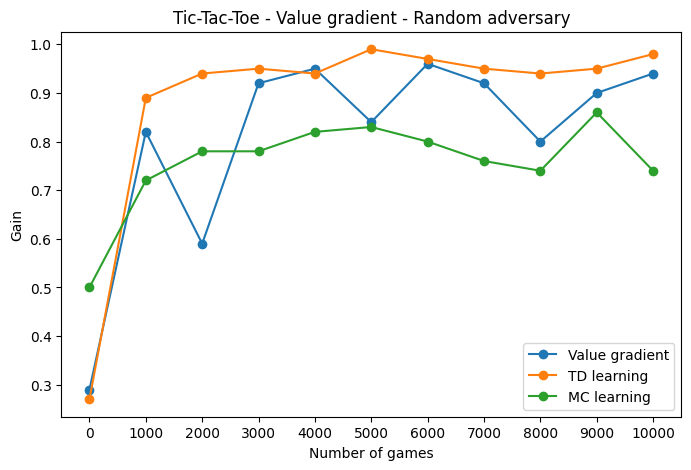

In [189]:
plot_gains(
    gains={
        "Value gradient": vg_gains,
        "TD learning": td_array,
        "MC learning": mc_array,
    },
    n_games=n_games,
    step=step,
    data_points=data_points,
    title="Tic-Tac-Toe - Value gradient - Random adversary",
)

#### Perfect adversary


In [190]:
algo = ValueIteration(game)
_, adversary_policy = algo.get_perfect_players()
game = TicTacToe(adversary_policy=adversary_policy)

In [191]:
data_points = 10
step = 1000
n_games = data_points * step
vg_gains = []

agent = ValueGradient(game)
gains = agent.get_gains(n_runs=100)
vg_gains.append(np.mean(gains))

for i in tqdm(range(1, data_points + 1)):
    agent.train(n_episodes=step * i)
    agent.update_policy()
    gains = agent.get_gains(n_runs=100)
    vg_gains.append(np.mean(gains))

  0%|          | 0/10 [00:00<?, ?it/s]

In [192]:
mc = MCLearning(game, policy="random")
mc_array = []

for i in tqdm(range(n_games + 1)):
    mc.update_values()
    mc.update_policy()

    if i % step == 0:
        gains = mc.get_gains(n_runs=100)
        mc_array.append(np.mean(gains))

  0%|          | 0/10001 [00:00<?, ?it/s]

In [193]:
td = TDLearning(game, policy="random")
td_array = []

for i in tqdm(range(n_games + 1)):
    td.update_values()
    td.update_policy()

    if i % step == 0:
        gains = td.get_gains(n_runs=100)
        td_array.append(np.mean(gains))

  0%|          | 0/10001 [00:00<?, ?it/s]

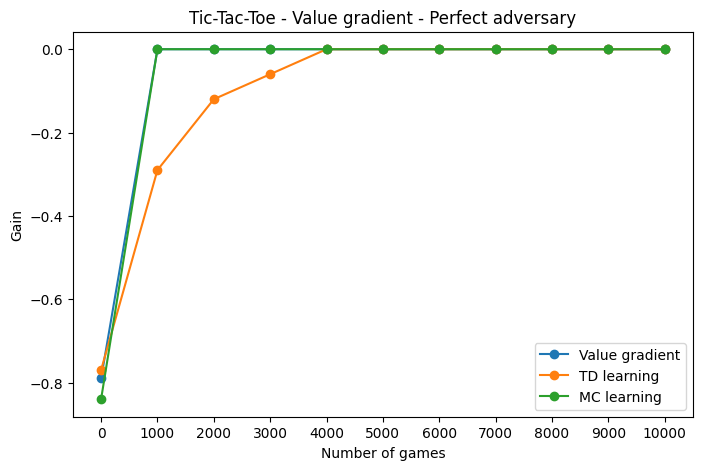

In [194]:
plot_gains(
    gains={
        "Value gradient": vg_gains,
        "TD learning": td_array,
        "MC learning": mc_array,
    },
    n_games=n_games,
    step=step,
    data_points=data_points,
    title="Tic-Tac-Toe - Value gradient - Perfect adversary",
)

### Connect Four


In [195]:
game = ConnectFour()
agent = ValueGradient(game)

In [196]:
gains = agent.get_gains(n_runs=100)
np.unique(gains, return_counts=True)

(array([-1,  1]), array([50, 50]))

#### Random adversary


In [197]:
data_points = 5
step = 500
n_games = data_points * step
vg_gains = []

agent = ValueGradient(game)
gains = agent.get_gains(n_runs=100)
vg_gains.append(np.mean(gains))

for i in tqdm(range(1, data_points + 1)):
    agent.train(n_episodes=step * i)
    agent.update_policy()
    gains = agent.get_gains(n_runs=100)
    vg_gains.append(np.mean(gains))

  0%|          | 0/5 [00:00<?, ?it/s]

In [198]:
mc = MCLearning(game, policy="random")
mc_array = []

for i in tqdm(range(n_games + 1)):
    mc.update_values()
    mc.update_policy()

    if i % step == 0:
        gains = mc.get_gains(n_runs=100)
        mc_array.append(np.mean(gains))

  0%|          | 0/2501 [00:00<?, ?it/s]

In [199]:
td = TDLearning(game, policy="random")
td_array = []

for i in tqdm(range(n_games + 1)):
    td.update_values()
    td.update_policy()

    if i % step == 0:
        gains = td.get_gains(n_runs=100)
        td_array.append(np.mean(gains))

  0%|          | 0/2501 [00:00<?, ?it/s]

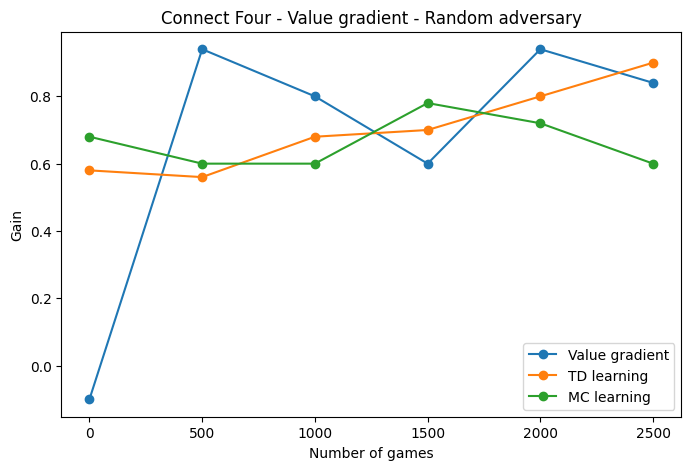

In [200]:
plot_gains(
    gains={
        "Value gradient": vg_gains,
        "TD learning": td_array,
        "MC learning": mc_array,
    },
    n_games=n_games,
    step=step,
    data_points=data_points,
    title="Connect Four - Value gradient - Random adversary",
)

#### One-step adversary


In [201]:
game = ConnectFour(adversary_policy="one_step")

In [202]:
data_points = 5
step = 500
n_games = data_points * step
vg_gains = []

agent = ValueGradient(game)
gains = agent.get_gains(n_runs=100)
vg_gains.append(np.mean(gains))

for i in tqdm(range(1, data_points + 1)):
    agent.train(n_episodes=step * i)
    agent.update_policy()
    gains = agent.get_gains(n_runs=100)
    vg_gains.append(np.mean(gains))

  0%|          | 0/5 [00:00<?, ?it/s]

In [203]:
mc = MCLearning(game, policy="random")
mc_array = []

for i in tqdm(range(n_games + 1)):
    mc.update_values()
    mc.update_policy()

    if i % step == 0:
        gains = mc.get_gains(n_runs=100)
        mc_array.append(np.mean(gains))

  0%|          | 0/2501 [00:00<?, ?it/s]

In [204]:
td = TDLearning(game, policy="random")
td_array = []

for i in tqdm(range(n_games + 1)):
    td.update_values()
    td.update_policy()

    if i % step == 0:
        gains = td.get_gains(n_runs=100)
        td_array.append(np.mean(gains))

  0%|          | 0/2501 [00:00<?, ?it/s]

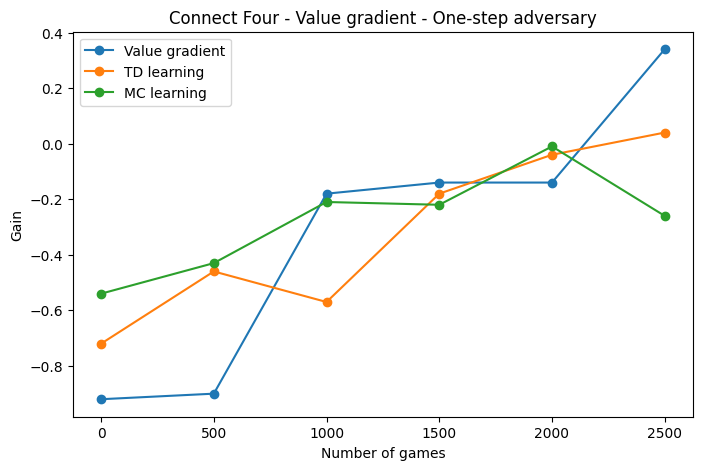

In [205]:
plot_gains(
    gains={
        "Value gradient": vg_gains,
        "TD learning": td_array,
        "MC learning": mc_array,
    },
    n_games=n_games,
    step=step,
    data_points=data_points,
    title="Connect Four - Value gradient - One-step adversary",
)

## Policy gradient


We now consider a policy-based method. The neural network is a classifier that approximates the optimal policy. It returns the probability of each action.


In [206]:
class Classifier(nn.Module):
    """Neural network for policy gradient. Return the distribution of actions in each state."""

    def __init__(self, model, hidden_size):
        if not hasattr(model, "one_hot_encode"):
            raise ValueError("The environment must have a one-hot encoding of states.")
        super(Classifier, self).__init__()
        self.model = model
        actions = model.get_all_actions()
        if self.model.is_game():
            # remove action when passing
            actions.pop()
        self.actions = actions
        state = model.init_state()
        code = model.one_hot_encode(state)
        input_size = len(code)
        output_size = len(actions)
        self.nn = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.GELU(),
            nn.Linear(hidden_size, output_size),
            nn.Softmax(dim=0),
        )

    def forward(self, code):
        """Forward pass."""
        return self.nn(code)

In [207]:
game = TicTacToe()
classifier = Classifier(model=game, hidden_size=100)

In [208]:
state = game.state
code = game.one_hot_encode(state)
code = torch.tensor(code).float()

In [209]:
probs = classifier.forward(code).detach()
print(probs)
print(len(probs))
print(sum(probs))

tensor([0.1100, 0.1130, 0.1182, 0.1220, 0.1164, 0.1111, 0.0989, 0.1051, 0.1052])
9
tensor(1.)


## To do

- Complete the method 'train' of the class PolicyGradient. Observe that a penalty is assigned for illegal actions.
- Test the agent on TicTacToe, against (1) a random adversary and (2) a perfect adversary.
- Test the agent on ConnectFour, against (1) a random adversary and (2) an adversary with the one-step policy.
- Compare your results to another learning strategy (e.g., Monte-Carlo learning) and interpret the results.
- (bonus) Try to improve policy gradient on TicTacToe with a perfect adversary.


In [210]:
class PolicyGradient(Agent):
    """Agent learning by policy gradient.

    Parameters
    ----------
    model : object of class Environment
        Model.a
    player : int
        Player for games (1 or -1, default = default player of the game).
    gamma : float
        Discount rate (in [0, 1], default = 1).
    hidden_size : int
        Size of the hidden layer (default = 100).
    penalty : float
        Penalty for illegal actions (default = -5).
    min_log : float
        Minimal value to compute the log (default = 1e-10)
    """

    def __init__(
        self, model, player=None, gamma=1, hidden_size=100, penalty=-1, min_log=1e-10
    ):
        super(PolicyGradient, self).__init__(model, player=player)
        self.nn = Classifier(model, hidden_size)
        self.action_id = {action: i for i, action in enumerate(self.nn.actions)}
        self.gamma = gamma
        self.penalty = penalty
        self.min_log = min_log
        self.running_mean_gain = 0

    def get_policy(self):
        """Get the current policy."""

        def policy(state):
            actions = self.model.get_actions(state)

            if len(actions) > 1:
                win_actions = []
                # check win actions
                if self.model.is_game():
                    next_states = [
                        self.model.get_next_state(state, action) for action in actions
                    ]
                    win_actions = [
                        self.model.get_reward(next_state) == self.player
                        for next_state in next_states
                    ]
                if any(win_actions):
                    probs = np.array(win_actions).astype(float)
                else:
                    # get prob of each action
                    code = self.model.one_hot_encode(state)
                    code = torch.tensor(code).float()
                    probs = self.nn.forward(code)
                    probs = probs.detach().numpy()
                    # restrict to available actions
                    indices = [self.action_id[action] for action in actions]
                    probs = probs[indices]
                # renormalize
                if np.sum(probs) > 0:
                    probs = probs / np.sum(probs)
                else:
                    probs = np.ones(len(actions)) / len(actions)
            else:
                probs = [1]
            return probs, actions

        return policy

    def update_policy(self):
        """Update the policy."""
        self.policy = self.get_policy()

    def get_samples(self, horizon):
        """Get samples from one episode."""
        self.update_policy()
        rewards = []
        log_probs = []
        log_probs_illegal = []
        self.model.reset()
        state = self.model.state

        for _ in range(horizon):
            action = self.get_action(state)
            if action is not None:
                i = self.action_id[action]
                code = self.model.one_hot_encode(state)
                code = torch.tensor(code).float()
                probs = self.nn.forward(code)
                prob = torch.clip(probs[i], self.min_log, 1 - self.min_log)
                log_prob = torch.log(prob).reshape(1)

                actions = self.model.get_actions(state)
                if action in actions:
                    reward, stop = self.model.step(action)
                    state = self.model.state
                    rewards.append(reward)
                    log_probs.append(log_prob)
                else:
                    log_probs_illegal.append(log_prob)
            else:
                reward, stop = self.model.step(action)
                rewards.append(reward)
                state = self.model.state
            if stop:
                break

        gain = 0
        for reward in reversed(rewards):
            gain = reward + self.gamma * gain

        return gain, log_probs, log_probs_illegal

    def train(self, horizon=100, n_episodes=1000, learning_rate=0.01):
        """Train the neural network."""
        optimizer = optim.Adam(self.nn.parameters(), lr=learning_rate)

        gains = []

        for _ in range(n_episodes):
            gain, log_probs, log_probs_illegal = self.get_samples(horizon)
            gains.append(gain)

            self.running_mean_gain += 0.01 * (gain - self.running_mean_gain)
            loss = 0

            if len(log_probs):
                # to be modified
                for log_prob in log_probs:
                    centered_gain = gain - self.running_mean_gain
                    for log_prob in log_probs:
                        loss += -log_prob * centered_gain

            if len(log_probs_illegal):
                for log_prob in log_probs_illegal:
                    loss += self.penalty * log_prob

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

### Tic-Tac-Toe


In [211]:
game = TicTacToe()
agent = PolicyGradient(game)

In [212]:
gains = agent.get_gains(n_runs=100)
np.unique(gains, return_counts=True)

(array([-1,  0,  1]), array([30, 16, 54]))

#### Random adversary


In [213]:
data_points = 10
step = 1000
n_games = data_points * step
pg_gains = []

agent = PolicyGradient(game)
gains = agent.get_gains(n_runs=100)
pg_gains.append(np.mean(gains))

for i in tqdm(range(1, data_points + 1)):
    agent.train(n_episodes=step * i)
    agent.update_policy()
    gains = agent.get_gains(n_runs=100)
    pg_gains.append(np.mean(gains))

  0%|          | 0/10 [00:00<?, ?it/s]

In [214]:
mc = MCLearning(game, policy="random")
mc_array = []
mc_array.append(np.mean(mc.get_gains(n_runs=100)))

for i in tqdm(range(1, n_games + 1)):
    mc.update_values()
    mc.update_policy()

    if i % step == 0 and i > 0:
        gains = mc.get_gains(n_runs=100)
        mc_array.append(np.mean(gains))

  0%|          | 0/10000 [00:00<?, ?it/s]

In [215]:
td = TDLearning(game, policy="random")
td_array = []
td_array.append(np.mean(td.get_gains(n_runs=100)))

for i in tqdm(range(1, n_games + 1)):
    td.update_values()
    td.update_policy()

    if i % step == 0 and i > 0:
        gains = td.get_gains(n_runs=100)
        td_array.append(np.mean(gains))

  0%|          | 0/10000 [00:00<?, ?it/s]

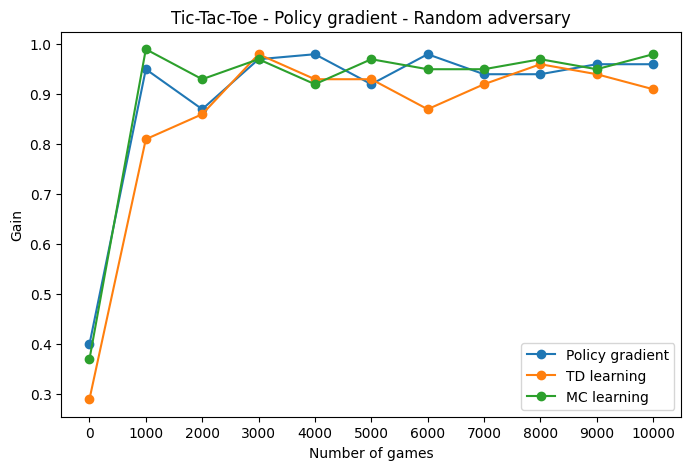

In [216]:
plot_gains(
    gains={
        "Policy gradient": pg_gains,
        "TD learning": td_array,
        "MC learning": mc_array,
    },
    n_games=n_games,
    step=step,
    data_points=data_points,
    title="Tic-Tac-Toe - Policy gradient - Random adversary",
)

#### Perfect adversary


In [217]:
algo = ValueIteration(game)
_, adversary_policy = algo.get_perfect_players()
game = TicTacToe(adversary_policy=adversary_policy)

In [218]:
data_points = 10
step = 1000
n_games = data_points * step
pg_gains = []

agent = PolicyGradient(game)
gains = agent.get_gains(n_runs=100)
pg_gains.append(np.mean(gains))

for i in tqdm(range(1, data_points + 1)):
    agent.train(n_episodes=step * i)
    agent.update_policy()
    gains = agent.get_gains(n_runs=100)
    pg_gains.append(np.mean(gains))

  0%|          | 0/10 [00:00<?, ?it/s]

In [219]:
mc = MCLearning(game, policy="random")
mc_array = []

for i in tqdm(range(n_games + 1)):
    mc.update_values()
    mc.update_policy()

    if i % step == 0:
        gains = mc.get_gains(n_runs=100)
        mc_array.append(np.mean(gains))

  0%|          | 0/10001 [00:00<?, ?it/s]

In [220]:
td = TDLearning(game, policy="random")
td_array = []

for i in tqdm(range(n_games + 1)):
    td.update_values()
    td.update_policy()

    if i % step == 0:
        gains = td.get_gains(n_runs=100)
        td_array.append(np.mean(gains))

  0%|          | 0/10001 [00:00<?, ?it/s]

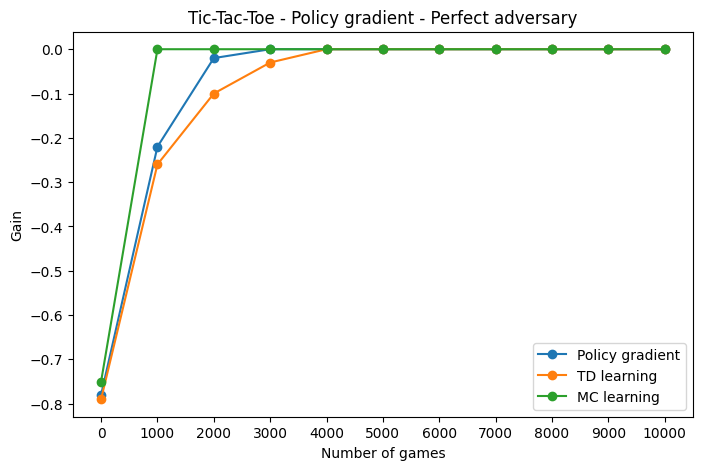

In [221]:
plot_gains(
    gains={
        "Policy gradient": pg_gains,
        "TD learning": td_array,
        "MC learning": mc_array,
    },
    n_games=n_games,
    step=step,
    data_points=data_points,
    title="Tic-Tac-Toe - Policy gradient - Perfect adversary",
)

### Connect Four


In [222]:
game = ConnectFour()
agent = PolicyGradient(game)

In [223]:
gains = agent.get_gains(n_runs=100)
np.unique(gains, return_counts=True)

(array([-1,  1]), array([41, 59]))

#### Random adversary


In [224]:
data_points = 5
step = 500
n_games = data_points * step
pg_gains = []

agent = PolicyGradient(game)
gains = agent.get_gains(n_runs=100)
pg_gains.append(np.mean(gains))

for i in tqdm(range(1, data_points + 1)):
    agent.train(n_episodes=step * i)
    agent.update_policy()
    gains = agent.get_gains(n_runs=100)
    pg_gains.append(np.mean(gains))

  0%|          | 0/5 [00:00<?, ?it/s]

In [225]:
mc = MCLearning(game, policy="random")
mc_array = []

for i in tqdm(range(n_games + 1)):
    mc.update_values()
    mc.update_policy()

    if i % step == 0:
        gains = mc.get_gains(n_runs=100)
        mc_array.append(np.mean(gains))

  0%|          | 0/2501 [00:00<?, ?it/s]

In [226]:
td = TDLearning(game, policy="random")
td_array = []

for i in tqdm(range(n_games + 1)):
    td.update_values()
    td.update_policy()

    if i % step == 0:
        gains = td.get_gains(n_runs=100)
        td_array.append(np.mean(gains))

  0%|          | 0/2501 [00:00<?, ?it/s]

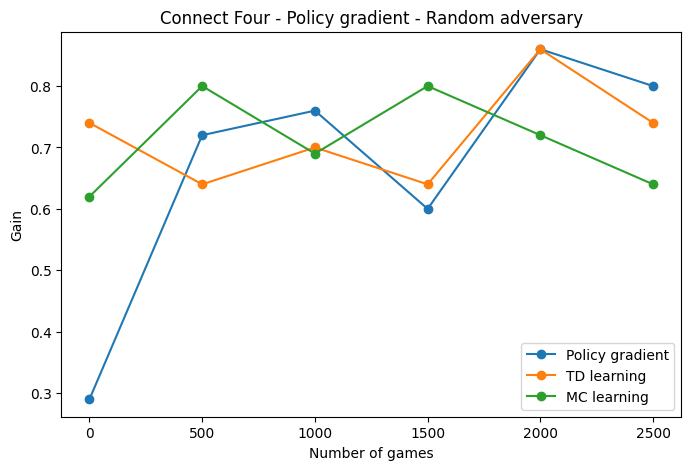

In [227]:
plot_gains(
    gains={
        "Policy gradient": pg_gains,
        "TD learning": td_array,
        "MC learning": mc_array,
    },
    n_games=n_games,
    step=step,
    data_points=data_points,
    title="Connect Four - Policy gradient - Random adversary",
)

#### One-step adversary


In [228]:
game = ConnectFour(adversary_policy="one_step")

In [229]:
data_points = 5
step = 500
n_games = data_points * step
pg_gains = []

agent = PolicyGradient(game)
gains = agent.get_gains(n_runs=100)
pg_gains.append(np.mean(gains))

for i in tqdm(range(1, data_points + 1)):
    agent.train(n_episodes=step * i)
    agent.update_policy()
    gains = agent.get_gains(n_runs=100)
    pg_gains.append(np.mean(gains))

  0%|          | 0/5 [00:00<?, ?it/s]

In [230]:
mc = MCLearning(game, policy="random")
mc_array = []

for i in tqdm(range(n_games + 1)):
    mc.update_values()
    mc.update_policy()

    if i % step == 0:
        gains = mc.get_gains(n_runs=100)
        mc_array.append(np.mean(gains))

  0%|          | 0/2501 [00:00<?, ?it/s]

In [231]:
td = TDLearning(game, policy="random")
td_array = []

for i in tqdm(range(n_games + 1)):
    td.update_values()
    td.update_policy()

    if i % step == 0:
        gains = td.get_gains(n_runs=100)
        td_array.append(np.mean(gains))

  0%|          | 0/2501 [00:00<?, ?it/s]

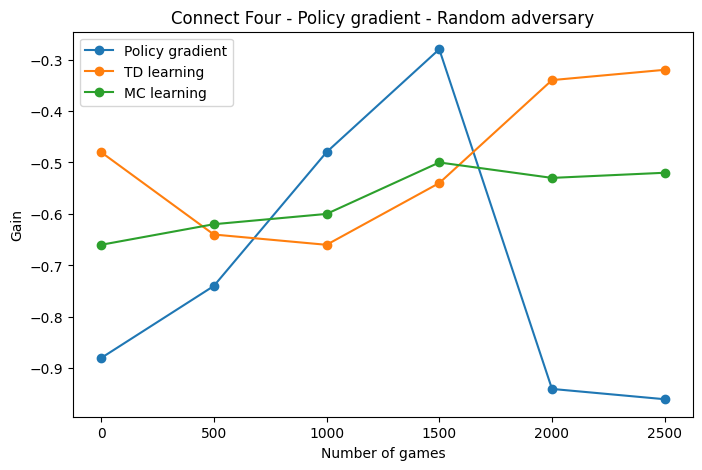

In [232]:
plot_gains(
    gains={
        "Policy gradient": pg_gains,
        "TD learning": td_array,
        "MC learning": mc_array,
    },
    n_games=n_games,
    step=step,
    data_points=data_points,
    title="Connect Four - Policy gradient - Random adversary",
)